In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Load and prepare training data

Get Calinfornia Housing data and split into train, test and validation sets.

In [11]:
housing = fetch_california_housing()

# test_size is default to 0.25
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [12]:
X_train_full.shape, X_train.shape, X_valid.shape, X_test.shape

((15480, 8), (11610, 8), (3870, 8), (5160, 8))

## Apply scaling

In [13]:
X_train = StandardScaler().fit_transform(X_train)
X_valid = StandardScaler().fit_transform(X_valid)
X_test = StandardScaler().fit_transform(X_test)

In [14]:
print(housing['feature_names'], housing['target_names'])

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] ['MedHouseVal']


## Building Non-Sequential Model

In this case, use the **Wide & Deep Model**:

- 2 Hidden Layers
- Input Layer is also combined with the output of the last hidden layer (connecting all inputer layer to output layer) 

The advantage of **Wide & Deep Model** makes it possible for model to learn both simple rules and deep patterns. 

In [33]:
tf.keras.backend.clear_session()

input_ = keras.layers.Input(shape = X_train.shape[1:])
hidden1_ = keras.layers.Dense(30, activation = "relu")(input_)
hidden2_ = keras.layers.Dense(30, activation = "relu")(hidden1_)
concat = keras.layers.Concatenate()([input_, hidden2_])
output = keras.layers.Dense(1)(concat)

model = keras.Model(inputs=[input_], outputs=[output])

In [34]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]         

In [38]:
tf.random.set_seed(1234)

model.compile(loss = 'mse', optimizer = 'sgd')

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs = 30, batch_size = 32, verbose = False)

mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3] 
y_pred = model.predict(X_new)

print(y_test[:3])
print(y_pred.reshape(1, -1))

162/162 [==============================] - 0s 525us/step - loss: 0.4719
[5.00001 2.603   1.828  ]
[[4.836974  1.68959   1.8006303]]


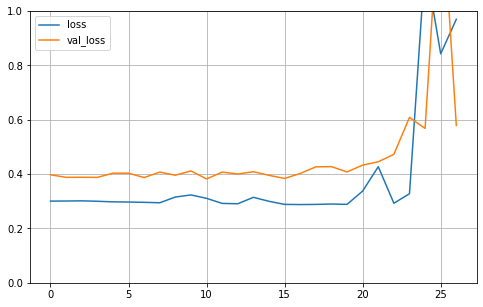

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

### Subsetting input and with auxilary output

- The task may demand it. For instance, you may want to locate and classify the main object in a picture. This can be both a regression (locating centre) and classification task (identify object). 
- May require different classes using similar data. For example, classify facial expression vs if someone is wearing glasses
- May be a regularisation technique to reduce overfitting

In [115]:
input_A = keras.layers.Input(shape = [5], name = "wide_input")
input_B = keras.layers.Input(shape = [6], name = "deep_input")

hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])

output = keras.layers.Dense(1, name = "output")(concat)
aux_output = keras.layers.Dense(1, name = "aux_output")(hidden2) # may feed into another network

model = keras.Model(inputs = [input_A, input_B], outputs = [output, aux_output])

model.compile(loss = ["mse", "mse"],
              loss_weights = [0.9, 0.1], # the weights can be focusing more on main and less so for aux for regularisation
              optimizer = keras.optimizers.SGD(lr = 1e-3)) #specify mulitple loss function for both outputs

model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 30)           930         dense_48[0][0]                   
______________________________________________________________________________________

In [93]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit([X_train_A, X_train_B], [y_train, y_train], 
                    epochs = 20, 
                    validation_data = ((X_valid_A, X_valid_B), (y_valid, y_valid)))

Epoch 1/20
363/363 [==============================] - 0s 1ms/step - loss: 2.4440 - output_loss: 2.2861 - aux_output_loss: 3.8650 - val_loss: 1.4620 - val_output_loss: 1.2953 - val_aux_output_loss: 2.9617
Epoch 2/20
363/363 [==============================] - 0s 821us/step - loss: 1.1039 - output_loss: 0.9601 - aux_output_loss: 2.3981 - val_loss: 1.0017 - val_output_loss: 0.8829 - val_aux_output_loss: 2.0703
Epoch 3/20
363/363 [==============================] - 0s 862us/step - loss: 0.8561 - output_loss: 0.7510 - aux_output_loss: 1.8017 - val_loss: 0.8441 - val_output_loss: 0.7485 - val_aux_output_loss: 1.7050
Epoch 4/20
363/363 [==============================] - 0s 799us/step - loss: 0.7662 - output_loss: 0.6782 - aux_output_loss: 1.5587 - val_loss: 0.7764 - val_output_loss: 0.6898 - val_aux_output_loss: 1.5561
Epoch 5/20
363/363 [==============================] - 0s 865us/step - loss: 0.7216 - output_loss: 0.6403 - aux_output_loss: 1.4538 - val_loss: 0.7376 - val_output_loss: 0.6547 - 

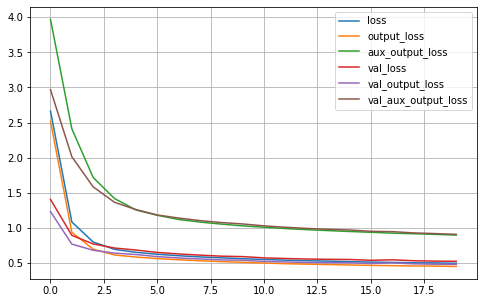

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [65]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 617us/step - loss: 0.5211 - output_loss: 0.4777 - aux_output_loss: 0.9110


In [66]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

In [67]:
print(y_pred_main, y_pred_aux, y_test[:3])

[[5.106239 ]
 [2.1479979]
 [1.8832926]] [[2.5263932]
 [2.3835902]
 [2.125881 ]] [5.00001 2.603   1.828  ]


## Subclassing API


In [83]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units = 30, activation = "relu", **kwargs):
        super().__init__(**kwargs) # handles standard arguments
        self.hidden1 = keras.layers.Dense(units, activation = activation)
        self.hidden2 = keras.layers.Dense(units, activation = activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs        
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([hidden2, input_A])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

#model = WideAndDeepModel()

In [91]:
#model.call([X_train_A, X_train_B])

## Save and Load Model

The model is safed using HDF5 format.

In [94]:
model.save("model.h5")

In [98]:
model = keras.models.load_model("model.h5")

## Using Call backs

The **fit()** methods accept **callbacks** argument that lets you specify a list of object that Keras will call at the start and end of training or epoch, or even batch. For example **ModelCheckpoint** callbask saves checkpoints of your model at regular intervals during training.

Set argument **save_best_only**, set to True if keep only the best.

Can also use **EarlyStopping** callback where traing is interrupted if there is no progress. This will save a lot of time.


In [124]:
tf.keras.backend.clear_session()

checkpoint_cp = keras.callbacks.ModelCheckpoint("keras_cb.h5", save_best_only=True) # set save best only to True to keep best train, valid result
early_stopping_cp = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
print_cp = PrintValTrainRationCallBack()

history = model.fit([X_train_A, X_train_B], [y_train, y_train], 
                    epochs = 20,  callbacks = [checkpoint_cp, early_stopping_cp, print_cp], verbose = False,
                    validation_data = ((X_valid_A, X_valid_B), (y_valid, y_valid)))


Val/Train: 1.271945

Val/Train: 1.274057

Val/Train: 1.281311

Val/Train: 1.276099

Val/Train: 1.282512

Val/Train: 1.287801

Val/Train: 1.279796

Val/Train: 1.281656

Val/Train: 1.281115

Val/Train: 1.279737

Val/Train: 1.279532

Val/Train: 1.282188

Val/Train: 1.281995

Val/Train: 1.288970

Val/Train: 1.281730

Val/Train: 1.291919

Val/Train: 1.285494

Val/Train: 1.295775

Val/Train: 1.287547

Val/Train: 1.286608


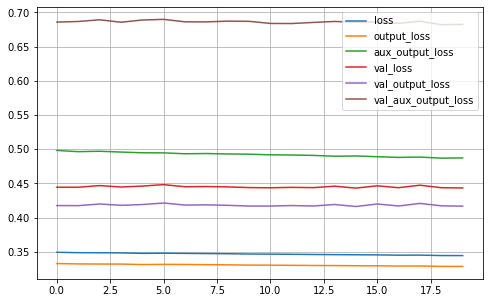

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

### Custom Call Back

We can also create our own call back functions

In [117]:
class PrintValTrainRationCallBack(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nVal/Train: {:2f}".format(logs["val_loss"]/logs["loss"]))

### Added to prvious section